In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.models import resnet50, ResNet50_Weights
from google.colab import drive
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/datasets.zip" -d "/content/datasets"
!cp "/content/drive/MyDrive/final_resnet50_amp_7.pth" "/content/final_resnet50_amp_7.pth"

# Remove Contempt
!mkdir '/content/separated_dataset'
!mkdir '/content/separated_test_dataset'
!mv '/content/datasets/separated_dataset/7' '/content/separated_dataset/7'
!mv '/content/datasets/separated_test_dataset/7' '/content/separated_test_dataset/7'

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

data_dir = '/content/datasets/separated_dataset'
test_data_dir = '/content/datasets/separated_test_dataset'

# transform and class weights
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Load full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
targets = full_dataset.targets

print("Classes:", full_dataset.classes)
num_classes = len(full_dataset.classes)

train_indices, val_indices = train_test_split(
    np.arange(len(targets)),
    test_size=0.05,
    random_state=seed,
    stratify=targets
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

test_dataset = datasets.ImageFolder(root=test_data_dir, transform=data_transforms)
print(f"Test size: {len(test_dataset)}")


targets = [label for _, label in full_dataset.samples]
class_counts = Counter(targets)
total_samples = len(targets)

weights = []
for i in range(num_classes):
    class_count = class_counts[i]
    weight = total_samples / (num_classes * class_count)
    weights.append(weight)

weights = torch.tensor(weights, dtype=torch.float32)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights = weights.to(device)

weights_model = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights_model)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()

batch_size = 64
num_workers = 2

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())

Mounted at /content/drive
Classes: ['0', '1', '2', '3', '4', '5', '6']
Train size: 269705, Val size: 14196
Test size: 3500
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]
/tmp/ipython-input-3405213924.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [2]:
model_save_path = "final_resnet50_amp_7.pth"
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
backbone = nn.Sequential(*list(model.children())[:-1])

model.eval()

def get_expression_embedding(x):
    with torch.no_grad():
        feat = backbone(x)
        feat = feat.view(feat.size(0), -1)
        emb = model.fc[0](feat)
        emb = model.fc[1](emb)
        emb = F.normalize(emb, p=2, dim=1)

    return emb

In [15]:
all_embeddings = []
all_labels = []

for images, labels in test_loader:
    images = images.to(device)
    emb = get_expression_embedding(images)

    all_embeddings.append(emb.cpu().numpy())
    all_labels.append(labels.numpy())


embeddings = np.concatenate(all_embeddings, axis=0)
labels = np.concatenate(all_labels, axis=0)

In [16]:
import umap

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)

embedding_2d = reducer.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


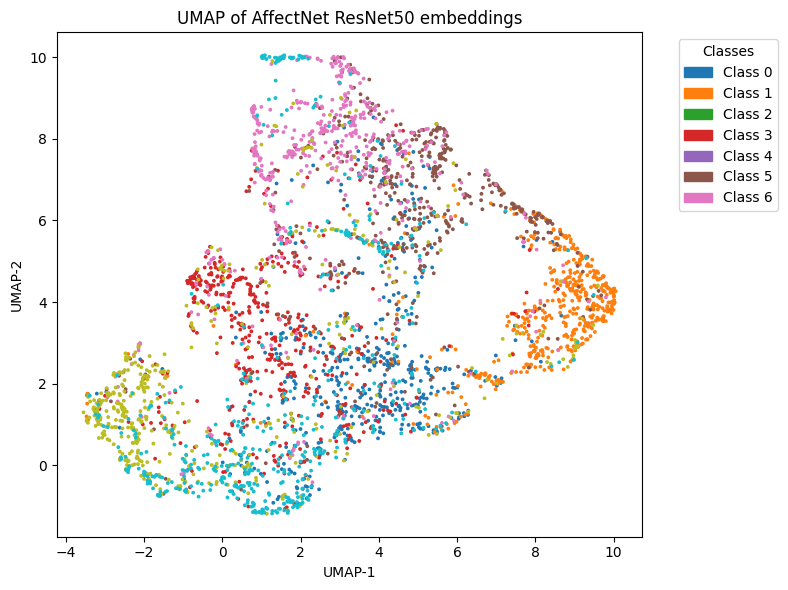

In [21]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    s=3,
    c=labels,
    cmap='tab10'
)

num_classes = 7
colors = plt.cm.tab10(range(num_classes))
labels_text = [f"Class {i}" for i in range(num_classes)]

patches = [
    mpatches.Patch(color=colors[i], label=labels_text[i])
    for i in range(num_classes)
]

plt.legend(
    handles=patches,
    title="Classes",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.title("UMAP of AffectNet ResNet50 embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()